# Identifying movie sequels using Semi-supervised learning

A movie sequel is a follow-up to a movie that came out previously, usually taking some of the same characters and themes to further explore or develop earlier storylines. Moviegoers are getting more and more accustomed to sequels, as they are widely used by studios to generate more profit from one original idea. Nowadays, sequels constitute a significant share of the movie industry, while it was practically inexistent half a century ago.

In this post, we want to identify if within a pair of movies, one is the sequel of the other. Intuitively, sequels would have similar metadata to the original movie, which should make it a sensible problem to tackle. 

Our first reflex would be to view this as a binary classification problem, where we would predict if a movie is the sequel of another or not. However, this requires having labels on what movies are sequels and more importantly, which are not. This is not a straightforward task. Several problems rapidly appear once you start thinking about it:

- While it is possible to find lists of sequels online, they usually are of limited size. This will limit our dataset quite significantly.
- There are obviously no lists of non-sequel movies available. The  majority of movies are not sequels, and the proportion of movie pairs with a sequel is virtually infinitesimal. One idea then would be to just randomly select pairs of movies and label them as non-sequels. While this would most likely be a fair assumption, this would build an awful dataset to learn from. If you are to draw two movies at random, they are most likely not going to share any attributes at all. A classifier trained on such data is likely to identify any movie pair as a sequel as soon as one actor is in common.
- Hence, the non-sequel movie pairs we want in our labeled dataset should not only be random, but also contain pairs that bear similarities despite not being sequels.

To overcome these challenges, we will collect the data in three independent steps:

- We will collect the sequel movies from <a href = "https://en.wikipedia.org/wiki/List_of_film_sequels_by_box-office_improvement">this wikipedia article</a>, which lists some movies and their sequels
- For the non-sequel movies, we will manually define a list of movies for which we know none was a sequel and add all the resulting pairs as non-sequels to the train set
- Finally, we will collect unlabeled data for all movies made by a couple of actors

Given that this data collection process is very limiting in terms of data volume, we are going to perform a comparison of supervised and semi-supervised algorithms to predict which movie pairs are sequels.

## 1. Load Data

As always, let us start with the packages we will need in this post.

In [0]:
%%capture
!pip install wikipedia -q
import wikipedia
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Load IMDB Data

To build features for each movie, we want to use the IMDB data available online. We will download three tables:
- "title.principals" maps movie IDs to actor and director IDs
- "title.basics" maps movie IDs to the title, year and genre
- "name.basics" maps actor and director IDs to their name

In [0]:
%%capture
! wget "https://datasets.imdbws.com/title.principals.tsv.gz"
! wget "https://datasets.imdbws.com/title.basics.tsv.gz"
! wget "https://datasets.imdbws.com/name.basics.tsv.gz"

! gunzip title.principals.tsv.gz
! gunzip title.basics.tsv.gz
! gunzip name.basics.tsv.gz

In [0]:
cast = pd.read_csv('title.principals.tsv', sep='\t', na_values = "\\N", keep_default_na = False, 
                   usecols = ['tconst','ordering','nconst','category'],
                   dtype = {'tconst': str, 'ordering': str, 'nconst': str, 'category': str})
titles = pd.read_csv('title.basics.tsv', sep='\t', na_values = "\\N", keep_default_na = False,
                     usecols = ['tconst','primaryTitle','startYear','titleType','genres'],
                    dtype = {'tconst': str, 'primaryTitle': str, 'startYear': 'Int64','titleType':str, 'genres': str})
names = pd.read_csv('name.basics.tsv', sep='\t', na_values = "\\N", keep_default_na = False,
                    usecols = ['nconst','primaryName'], 
                    dtype = {'nconst': str, 'primaryName': str})

In [0]:
titles = titles[titles.titleType == 'movie'] #keep only movies
cast = cast[cast.category.isin(['director','actor','actress'])] #only keep actors, actresses and directors

### Get the sequel movie pairs

In <a href = "https://en.wikipedia.org/wiki/List_of_film_sequels_by_box-office_improvement">this wikipedia page</a>, there is a list of movies and their sequels. All these movie titles can be found extracted as they are coded as links to the corresponding wikipedia page. The code below queries all links from the wikipedia page.

In [0]:
S = requests.Session()

URL = "https://en.wikipedia.org/w/api.php"

PARAMS = {
    "action": "query",
    "format": "json",
    "titles": "List_of_film_sequels_by_box-office_improvement",
    "prop": "links",
    "pllimit": 500
}

R = S.get(url=URL, params=PARAMS)
DATA = R.json()

PAGES = DATA["query"]["pages"]

sequels = []
for k, v in PAGES.items():
    for l in v["links"]:
        sequels.append(l["title"])

print(sequels[:5])

We then go through this list to find which are sequels by checking if within the pair, one wikipedia article summary references the other. For instance, this is what can be found in the first sentences of the description of <a href = "https://en.wikipedia.org/wiki/The_Godfather_Part_II">The Godfather Part II on wikipedia</a>: 

> *The Godfather Part II* is a 1974 American crime film produced and directed by Francis Ford Coppola from a screenplay co-written with Mario Puzo, starring Al Pacino and Robert De Niro. Partially based on Puzo's 1969 novel *The Godfather*, the film is both sequel and prequel to *The Godfather*, presenting parallel dramas: one picks up the 1958 story of Michael Corleone (Pacino), the new Don of the Corleone crime family, protecting the family business in the aftermath of an attempt on his life; the prequel covers the journey of his father, Vito Corleone (De Niro), from his Sicilian childhood to the founding of his family enterprise in New York City.

We can see in this example that *The Godfather Part II* references *The Godfather*, thus we can assume both movies are a sequel pair.

The code below executes this logic.

In [0]:
first_movie_list = []
sequel_movie_list = []
for sequel in sequels: #looping through the link titles
    page = wikipedia.page(sequel) #get the wikipedia page of this title
    summary = page.summary #get the wikipedia summary of the page
    for first_movie in sequels: #looping through the link titles
        if first_movie in summary and first_movie != sequel: #if the first movie gets referenced, add both to list
            first_movie_list.append(first_movie)
            sequel_movie_list.append(sequel)

In [0]:
def remove_film_year(sequel):
    if "(" in sequel:
        i = sequel.index("(")
        return sequel[0:i-1]
    return sequel

first_movie_list = [remove_film_year(first_movie) for first_movie in first_movie_list]
sequel_movie_list = [remove_film_year(sequel) for sequel in sequel_movie_list]

### Get the non-sequel movie pairs

As outlined above, we want the non-sequel movie pairs to be not chosen at random to avoid them being too different. The list below is made of movies for which there were no sequels (to the best of our knowledge), and they were chosen so that some would have similarities:
- *The Searchers* and *She Wore a Yellow Ribbon* are both westerns with John Wayne directed by John Ford, with 7 years difference
- *There Will Be Blood* and *Phantom Thread* are both starring Daniel Day-Lewis and were directed by Paul Thomas Anderson, with 10 years difference
- *Little Big Man* and *Bonnie and Clyde* both feature Faye Dunaway and were directed by Arthur Penn, with 3 years difference
- *The Shawshank Redemption* and *Escape from Alcatraz* are both movies about escaping prison
- *Little Big Horn* and *Little Big Man* obviously are very close in title and are both westerns
- etc

We compute all the pairs using these movies for the non-sequel movie pairs in our train data.

In [0]:
non_sequel_movies = ['The Searchers','Chisum','She Wore a Yellow Ribbon','There Will Be Blood','Phantom Thread','Little Big Man',
                     'Bonnie and Clyde','Out of Africa','Silkwood','Florence Foster Jenkins','The Shawshank Redemption',
                     'Escape from Alcatraz','Little Big Horn','American Beauty','An American in Paris']

ns_first_movie_list = []
ns_sequel_movie_list = []
for first_movie in non_sequel_movies:
    for sequel_movie in non_sequel_movies:
        if first_movie != sequel_movie:
            ns_first_movie_list.append(first_movie)
            ns_sequel_movie_list.append(sequel_movie)

### Get the unlabeled movie pairs

The unlabeled movie pairs are the pairs for which we would like to get the labels, ie to determine whether these are sequels or not. For this, we select 4 directors, 2 actors and 2 actresses, for which we select all the respective pairwise combination of movies.

In [0]:
actors_for_unsupervised = ['Al Pacino','Jack Nicholson','Jennifer Lawrence','Jodie Foster']
directors_for_unsupervised = ['Alfred Hitchcock','Steven Spielberg','George Lucas','David Lean']
names_for_unsupervised = actors_for_unsupervised + directors_for_unsupervised

In [0]:
cast_movies = pd.merge(names[names.primaryName.isin(names_for_unsupervised)],cast, on = 'nconst', how = 'inner')
cast_titles = pd.merge(cast_movies, titles, on = 'tconst', how = 'inner')

In [0]:
unlabeled_first_movie_list = []
unlabeled_sequel_movie_list = []

for name in names_for_unsupervised:
    name_movies = cast_titles[cast_titles.primaryName == name].primaryTitle.unique()
    for first_movie in name_movies:
        for sequel_movie in name_movies:
            if first_movie != sequel_movie:
                unlabeled_first_movie_list.append(first_movie)
                unlabeled_sequel_movie_list.append(sequel_movie)

## 2. Data Preparation

Now that we have loaded the lists of movies we want to be considering as movie pairs for our project, we need to prepare the data. Our goal is to construct a dataframe where each row would represent a pair of movies with their corresponding information.

In [0]:
def prepare_data(first_movie_list, sequel_movie_list):
    # Join movie lists to their IMDB data
    movie_titles = titles[titles.primaryTitle.isin(first_movie_list + sequel_movie_list)].copy()
    movie_titles.drop_duplicates(subset = 'primaryTitle', keep = False, inplace = True)
    movie_titles = pd.merge(movie_titles, cast, on = 'tconst')
    movie_titles = pd.merge(movie_titles, names, on = 'nconst')
    movie_titles = movie_titles.drop(columns = ['titleType','tconst','nconst'])

    # Pivot the table by pushing the cast and directors to columns
    movie_information = movie_titles.replace(['actor','actress','director'], ['act','act','dir'])
    movie_information['role'] = movie_information.category + movie_information.ordering
    movie_summary = pd.pivot_table(movie_information, columns = 'role', values = 'primaryName', index = ['primaryTitle','startYear','genres'], aggfunc = 'first') #add genres back
    movie_summary = movie_summary[['act1','act2','act3','act4','dir5']].reset_index()
    
    # Add prefixes to the columns to distinguish the first movies from the sequels
    first_movie_titles = movie_summary[movie_summary.primaryTitle.isin(first_movie_list)]
    first_movie_titles = first_movie_titles.add_prefix('fm_')
    sequel_movie_titles = movie_summary[movie_summary.primaryTitle.isin(sequel_movie_list)]
    sequel_movie_titles = sequel_movie_titles.add_prefix('s_')

    sequel_pairs = pd.DataFrame({"first_movie" : first_movie_list, "sequel" : sequel_movie_list})

    # Join the first movies with the sequels, check that the year of the sequel is after the year of the first movie
    sequel_table = pd.merge(pd.merge(first_movie_titles, sequel_pairs, left_on = 'fm_primaryTitle', right_on = 'first_movie', how = 'inner'),
                        sequel_movie_titles, left_on = 'sequel', right_on = 's_primaryTitle', how = 'inner')
    sequel_table = sequel_table[sequel_table.fm_startYear <= sequel_table.s_startYear].copy()
    sequel_table.drop(columns = ['first_movie','sequel'], inplace = True)

    return sequel_table

Eventually, we can apply this function to each of our three data sets: the sequels, the non-sequels and the unlabeled movie pairs.

In [0]:
sequel_table = prepare_data(first_movie_list, sequel_movie_list)
sequel_table.head()

,fm_primaryTitle,fm_startYear,fm_genres,fm_act1,fm_act2,fm_act3,fm_act4,fm_dir5,s_primaryTitle,s_startYear,s_genres,s_act1,s_act2,s_act3,s_act4,s_dir5
1,A Fistful of Dollars,1964,"Drama,Western",Clint Eastwood,Gian Maria Volontè,Marianne Koch,Wolfgang Lukschy,Sergio Leone,For a Few Dollars More,1965,Western,Clint Eastwood,Lee Van Cleef,Gian Maria Volontè,Mario Brega,Sergio Leone
2,Ace Ventura: Pet Detective,1994,Comedy,Jim Carrey,Courteney Cox,Sean Young,Tone Loc,Tom Shadyac,Ace Ventura: When Nature Calls,1995,"Adventure,Comedy,Crime",Jim Carrey,Ian McNeice,Simon Callow,Maynard Eziashi,Steve Oedekerk
4,Alvin and the Chipmunks,2007,"Animation,Comedy,Family",Jason Lee,Ross Bagdasarian Jr.,Janice Karman,David Cross,Tim Hill,Alvin and the Chipmunks: The Squeakquel,2009,"Animation,Comedy,Family",Jason Lee,Zachary Levi,David Cross,Justin Long,Betty Thomas
6,Anchorman: The Legend of Ron Burgundy,2004,Comedy,Will Ferrell,Christina Applegate,Steve Carell,Paul Rudd,Adam McKay,Anchorman 2: The Legend Continues,2013,Comedy,Will Ferrell,Christina Applegate,Paul Rudd,Steve Carell,Adam McKay
11,Avengers: Age of Ultron,2015,"Action,Adventure,Sci-Fi",Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Joss Whedon,Avengers: Endgame,2019,"Action,Adventure,Drama",Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Anthony Russo


In [0]:
non_sequel_table = prepare_data(ns_first_movie_list, ns_sequel_movie_list)
non_sequel_table.head()

,fm_primaryTitle,fm_startYear,fm_genres,fm_act1,fm_act2,fm_act3,fm_act4,fm_dir5,s_primaryTitle,s_startYear,s_genres,s_act1,s_act2,s_act3,s_act4,s_dir5
1,An American in Paris,1951,"Drama,Musical,Romance",Gene Kelly,Leslie Caron,Oscar Levant,Georges Guétary,Vincente Minnelli,The Searchers,1956,"Adventure,Drama,Western",John Wayne,Jeffrey Hunter,Vera Miles,Ward Bond,John Ford
6,Little Big Horn,1951,Western,Lloyd Bridges,John Ireland,Marie Windsor,Reed Hadley,Charles Marquis Warren,The Searchers,1956,"Adventure,Drama,Western",John Wayne,Jeffrey Hunter,Vera Miles,Ward Bond,John Ford
10,She Wore a Yellow Ribbon,1949,Western,John Wayne,Joanne Dru,John Agar,Ben Johnson,John Ford,The Searchers,1956,"Adventure,Drama,Western",John Wayne,Jeffrey Hunter,Vera Miles,Ward Bond,John Ford
15,An American in Paris,1951,"Drama,Musical,Romance",Gene Kelly,Leslie Caron,Oscar Levant,Georges Guétary,Vincente Minnelli,Chisum,1970,"Biography,Western",John Wayne,Forrest Tucker,Christopher George,Ben Johnson,Andrew V. McLaglen
16,Bonnie and Clyde,1967,"Action,Biography,Crime",Warren Beatty,Faye Dunaway,Michael J. Pollard,Gene Hackman,Arthur Penn,Chisum,1970,"Biography,Western",John Wayne,Forrest Tucker,Christopher George,Ben Johnson,Andrew V. McLaglen


In [0]:
unlabeled_table = prepare_data(unlabeled_first_movie_list, unlabeled_sequel_movie_list)
unlabeled_table.head()

,fm_primaryTitle,fm_startYear,fm_genres,fm_act1,fm_act2,fm_act3,fm_act4,fm_dir5,s_primaryTitle,s_startYear,s_genres,s_act1,s_act2,s_act3,s_act4,s_dir5
40,The Sugarland Express,1974,"Crime,Drama",Goldie Hawn,Ben Johnson,Michael Sacks,William Atherton,Steven Spielberg,Jaws,1975,"Adventure,Drama,Thriller",Roy Scheider,Robert Shaw,Richard Dreyfuss,Lorraine Gary,Steven Spielberg
53,Jaws,1975,"Adventure,Drama,Thriller",Roy Scheider,Robert Shaw,Richard Dreyfuss,Lorraine Gary,Steven Spielberg,Close Encounters of the Third Kind,1977,"Drama,Sci-Fi",Richard Dreyfuss,François Truffaut,Teri Garr,Melinda Dillon,Steven Spielberg
62,The Sugarland Express,1974,"Crime,Drama",Goldie Hawn,Ben Johnson,Michael Sacks,William Atherton,Steven Spielberg,Close Encounters of the Third Kind,1977,"Drama,Sci-Fi",Richard Dreyfuss,François Truffaut,Teri Garr,Melinda Dillon,Steven Spielberg
66,1941,1979,"Action,Comedy,War",John Belushi,Dan Aykroyd,Treat Williams,Nancy Allen,Steven Spielberg,Raiders of the Lost Ark,1981,"Action,Adventure",Harrison Ford,Karen Allen,Paul Freeman,John Rhys-Davies,Steven Spielberg
70,Close Encounters of the Third Kind,1977,"Drama,Sci-Fi",Richard Dreyfuss,François Truffaut,Teri Garr,Melinda Dillon,Steven Spielberg,Raiders of the Lost Ark,1981,"Action,Adventure",Harrison Ford,Karen Allen,Paul Freeman,John Rhys-Davies,Steven Spielberg


Finally, let us concatenate these three tables into one data set after labeling them. We assign the arbitrary label -1 when the movie pairs is unlabeled.

In [0]:
sequel_table['sequel'] = 1
non_sequel_table['sequel'] = 0
unlabeled_table['sequel'] = -1
movie_pairs = pd.concat([sequel_table,non_sequel_table,unlabeled_table], axis = 0)
movie_pairs.head()

,fm_primaryTitle,fm_startYear,fm_genres,fm_act1,fm_act2,fm_act3,fm_act4,fm_dir5,s_primaryTitle,s_startYear,s_genres,s_act1,s_act2,s_act3,s_act4,s_dir5,sequel
1,A Fistful of Dollars,1964,"Drama,Western",Clint Eastwood,Gian Maria Volontè,Marianne Koch,Wolfgang Lukschy,Sergio Leone,For a Few Dollars More,1965,Western,Clint Eastwood,Lee Van Cleef,Gian Maria Volontè,Mario Brega,Sergio Leone,1
2,Ace Ventura: Pet Detective,1994,Comedy,Jim Carrey,Courteney Cox,Sean Young,Tone Loc,Tom Shadyac,Ace Ventura: When Nature Calls,1995,"Adventure,Comedy,Crime",Jim Carrey,Ian McNeice,Simon Callow,Maynard Eziashi,Steve Oedekerk,1
4,Alvin and the Chipmunks,2007,"Animation,Comedy,Family",Jason Lee,Ross Bagdasarian Jr.,Janice Karman,David Cross,Tim Hill,Alvin and the Chipmunks: The Squeakquel,2009,"Animation,Comedy,Family",Jason Lee,Zachary Levi,David Cross,Justin Long,Betty Thomas,1
6,Anchorman: The Legend of Ron Burgundy,2004,Comedy,Will Ferrell,Christina Applegate,Steve Carell,Paul Rudd,Adam McKay,Anchorman 2: The Legend Continues,2013,Comedy,Will Ferrell,Christina Applegate,Paul Rudd,Steve Carell,Adam McKay,1
11,Avengers: Age of Ultron,2015,"Action,Adventure,Sci-Fi",Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Joss Whedon,Avengers: Endgame,2019,"Action,Adventure,Drama",Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Anthony Russo,1


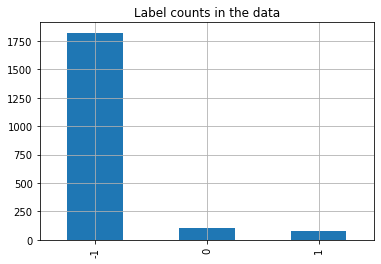

In [0]:
movie_pairs.sequel.value_counts().plot(kind='bar')
plt.title('Label counts in the data')
plt.grid()

From this chart, we can see that we have slightly more non-sequels than sequels in our data set now. We obviously have way more unlabeled movie pairs, as we have a virtually unlimited amount of unlabeled movie pairs at our disposal.

### Getting the movie plots

The table above has mostly metadata about each of the movie pairs. This is obviously helpful as you would expect metadata to be similar when a sequel was made. However, it would also be insightful to get the movie plots, which we could then leverage with NLP tools to identify similarities between plots.

To get the plots, we can still use the wikipedia API and extract the "Plot" section of the movie pages. Note that this terminology is not consistent throughout all wikipedia pages, which is why we need to look for sections such as "Synopsis" or "Plot summary" in case "Plot" was not found.

In [0]:
def get_plot(movie_table):
    plot_list = {}
    plot_not_found = []
    movie_list = np.array(pd.concat([movie_table.fm_primaryTitle, movie_table.s_primaryTitle]))
    year_list = np.array(pd.concat([movie_table.fm_startYear, movie_table.s_startYear]))
    for movie, year in zip(movie_list, year_list):
        if movie not in plot_list and movie not in plot_not_found:
            movie_y_f, movie_f = movie + ' (' + str(year) + ' film)', movie + ' (film)'
            search1 = wikipedia.search(movie_y_f)[0]
            search2 = wikipedia.search(movie_f)[0]
            if search1 == movie_y_f:
                search = movie_y_f
            elif search2 == movie_f:
                search = movie_f
            else:
                search = movie
            try:
                page = wikipedia.page(search)
                plot = page.section("Plot")
                if not plot:
                    plot = page.section("Synopsis")
                if not plot:
                    plot = page.section("Plot summary")
                if not plot:
                    plot = page.section("Summary")
                if plot:
                    plot_list[movie] = plot
                else:
                    plot_not_found.append(movie)
                    print('plot not found: %s' %movie)
            except:
                print('movie not found: %s' %movie)
                plot_not_found.append(movie)
                pass

    return plot_list

In [0]:
movie_plots = get_plot(movie_pairs)

A Fistful of Dollars
Ace Ventura: Pet Detective
Alvin and the Chipmunks
Anchorman: The Legend of Ron Burgundy
Avengers: Age of Ultron
Avengers: Infinity War
Batman Begins
Batman Returns
Blade Runner
Captain America: The First Avenger
Captain America: The Winter Soldier
Clerks
Despicable Me
Diary of a Mad Black Woman
Die Hard
Die Hard 2
Toy Story
Dirty Harry
El Mariachi
Evil Dead II
Final Destination 2
Finding Dory
The Incredibles
Toy Story 3
Finding Nemo
Halloween III: Season of the Witch
Harold & Kumar Go to White Castle
Harry Potter and the Prisoner of Azkaban
Hellbound: Hellraiser II
House of 1000 Corpses
Indiana Jones and the Temple of Doom
Iron Man 2
Jackass: The Movie
The Matrix
Lethal Weapon
Mad Max
Madagascar: Escape 2 Africa
Shrek
Monsters, Inc.
Pirates of the Caribbean: The Curse of the Black Pearl
The Lord of the Rings: The Return of the King
Pitch Perfect
Quantum of Solace
Resident Evil: Apocalypse
Resident Evil: Extinction
Rise of the Planet of the Apes
Rocky II
Shanghai N

In [0]:
documents = list(movie_plots.values())
doc_titles = list(movie_plots.keys())

In [0]:
movie_pairs = movie_pairs[(movie_pairs.fm_primaryTitle.isin(doc_titles)) & (movie_pairs.s_primaryTitle.isin(doc_titles))].copy()

## 3. Feature construction

In [0]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
stopwords_set = set(stopwords.words('english'))

In [0]:
def clean_text(document):
    document_lower = document.lower() # set everything to lower case
    document_no_punctuation = document_lower.translate(str.maketrans('', '', string.punctuation)) # strip all punctuation
    words = document_no_punctuation.split()
    words_no_stopwords = [word for word in words if word not in stopwords_set]
    return words_no_stopwords[0:100]

In [0]:
documents_text = [clean_text(document) for document in documents]

In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [0]:
documents_tagged = [TaggedDocument(doc, [doc_titles[i]]) for i, doc in enumerate(documents_text)]
model = Doc2Vec(documents_tagged, vector_size=100, window=2, min_count=1, workers=4)

In [0]:
max_epochs = 100
vec_size = 100
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=3,
                dm =1)
  
model.build_vocab(documents_tagged)

for epoch in range(max_epochs):
    model.train(documents_tagged,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0005
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  app.launch_new_instance()


In [0]:
model.docvecs[0]

array([-2.5194614 , -0.0647763 , -0.37928525, -0.46672255, -2.2716916 ,
       -0.7800351 ,  0.10549486,  0.29400286, -1.0610323 , -0.5507792 ,
       -2.4504576 ,  1.8233545 , -0.3825442 ,  1.3654914 , -1.8708978 ,
       -2.765761  , -2.6936297 , -3.5530086 ,  0.06513973, -3.3020015 ,
       -2.6017628 ,  3.09313   ,  2.0507262 ,  0.3510441 ,  1.0559995 ,
        2.4000027 , -1.9530219 , -1.1620113 , -1.5587314 ,  0.8099251 ,
       -3.6329026 ,  1.806493  ,  0.26893082,  2.4783547 ,  0.9705215 ,
        0.95041627,  1.4337366 ,  1.1081353 , -1.1428593 , -0.45407194,
       -1.3515459 , -3.902148  ,  2.4808922 , -1.0357152 , -0.23069394,
        1.5876384 ,  0.18585075, -0.8622152 , -2.3101873 ,  2.0802    ,
       -0.05943231, -0.79998773, -0.55250865, -0.16551173, -0.03693012,
        1.2194659 , -0.7942102 , -0.9982069 , -1.1533071 ,  0.34318218,
        0.16884594, -0.10124138,  0.9000363 , -1.5938396 ,  0.8710779 ,
       -0.9091085 ,  0.898878  , -0.29600665,  0.5609815 , -0.29

In [0]:
model.docvecs.most_similar([model.docvecs[2]])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Alvin and the Chipmunks', 0.9999998807907104),
 ('Alvin and the Chipmunks: The Squeakquel', 0.7370685338973999),
 ('Anger Management', 0.6557773947715759),
 ("Carlito's Way", 0.6423021554946899),
 ('The Rebel Rousers', 0.6394031047821045),
 ('A.I. Artificial Intelligence', 0.6235583424568176),
 ('Rear Window', 0.5949772596359253),
 ('Little Man Tate', 0.5935031175613403),
 ('The Humbling', 0.59269779920578),
 ('Blade Runner 2049', 0.5873045921325684)]

In [0]:
model.docvecs.most_similar([model.docvecs['Rear Window']], topn = 5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Rear Window', 0.9999999403953552),
 ("One Flew Over the Cuckoo's Nest", 0.6853747367858887),
 ('An American in Paris', 0.668846845626831),
 ('Elstree Calling', 0.6281954050064087),
 ('The Rebel Rousers', 0.6185281872749329)]

In [0]:
model.docvecs.most_similar([model.docvecs['Blade Runner']], topn = 5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Blade Runner', 1.0),
 ('Blade Runner 2049', 0.7617223262786865),
 ('The Rebel Rousers', 0.674165666103363),
 ('Despicable Me', 0.6049336194992065),
 ('Bugsy Malone', 0.5977593064308167)]

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
cosine_similarity([model.docvecs['Dirty Harry']],[model.docvecs['Magnum Force']])

array([[0.57758594]], dtype=float32)

In [0]:
cosine_similarity(np.array([model.docvecs['Dirty Harry']]),np.array([model.docvecs['Magnum Force'], model.docvecs['Sudden Impact']]))

array([[0.57758594, 0.5155606 ]], dtype=float32)

In [0]:
cosine_similarities = cosine_similarity(np.array([model.docvecs[doc_title] for doc_title in doc_titles]))

In [0]:
cosine_similarities

array([[1.0000002 , 0.42951035, 0.3751808 , ..., 0.45826522, 0.3578394 ,
        0.385032  ],
       [0.42951035, 0.9999997 , 0.45610437, ..., 0.5115312 , 0.45454633,
        0.5151878 ],
       [0.3751808 , 0.45610437, 0.99999976, ..., 0.4296833 , 0.43968487,
        0.36159638],
       ...,
       [0.45826522, 0.5115312 , 0.4296833 , ..., 1.0000002 , 0.42696398,
        0.45930555],
       [0.3578394 , 0.45454633, 0.43968487, ..., 0.42696398, 0.99999976,
        0.5315406 ],
       [0.385032  , 0.5151878 , 0.36159638, ..., 0.45930555, 0.5315406 ,
        1.0000001 ]], dtype=float32)

In [0]:
movie_pairs.head()

,fm_primaryTitle,fm_startYear,fm_genres,fm_act1,fm_act2,fm_act3,fm_act4,fm_dir5,s_primaryTitle,s_startYear,s_genres,s_act1,s_act2,s_act3,s_act4,s_dir5,sequel
1,A Fistful of Dollars,1964,"Drama,Western",Clint Eastwood,Gian Maria Volontè,Marianne Koch,Wolfgang Lukschy,Sergio Leone,For a Few Dollars More,1965,Western,Clint Eastwood,Lee Van Cleef,Gian Maria Volontè,Mario Brega,Sergio Leone,1
2,Ace Ventura: Pet Detective,1994,Comedy,Jim Carrey,Courteney Cox,Sean Young,Tone Loc,Tom Shadyac,Ace Ventura: When Nature Calls,1995,"Adventure,Comedy,Crime",Jim Carrey,Ian McNeice,Simon Callow,Maynard Eziashi,Steve Oedekerk,1
4,Alvin and the Chipmunks,2007,"Animation,Comedy,Family",Jason Lee,Ross Bagdasarian Jr.,Janice Karman,David Cross,Tim Hill,Alvin and the Chipmunks: The Squeakquel,2009,"Animation,Comedy,Family",Jason Lee,Zachary Levi,David Cross,Justin Long,Betty Thomas,1
6,Anchorman: The Legend of Ron Burgundy,2004,Comedy,Will Ferrell,Christina Applegate,Steve Carell,Paul Rudd,Adam McKay,Anchorman 2: The Legend Continues,2013,Comedy,Will Ferrell,Christina Applegate,Paul Rudd,Steve Carell,Adam McKay,1
11,Avengers: Age of Ultron,2015,"Action,Adventure,Sci-Fi",Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Joss Whedon,Avengers: Endgame,2019,"Action,Adventure,Drama",Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Anthony Russo,1


In [0]:
title_to_index = {}
for index, doc_title in enumerate(doc_titles):
    title_to_index[doc_title] = index

In [0]:
fm_index = np.array(movie_pairs.fm_primaryTitle.map(title_to_index))
s_index = np.array(movie_pairs.s_primaryTitle.map(title_to_index))


movie_pairs['plot_cosine'] = cosine_similarities[fm_index,s_index]

In [0]:
movie_pairs.head()

,fm_primaryTitle,fm_startYear,fm_genres,fm_act1,fm_act2,fm_act3,fm_act4,fm_dir5,s_primaryTitle,s_startYear,s_genres,s_act1,s_act2,s_act3,s_act4,s_dir5,sequel,plot_cosine
1,A Fistful of Dollars,1964,"Drama,Western",Clint Eastwood,Gian Maria Volontè,Marianne Koch,Wolfgang Lukschy,Sergio Leone,For a Few Dollars More,1965,Western,Clint Eastwood,Lee Van Cleef,Gian Maria Volontè,Mario Brega,Sergio Leone,1,0.548156
2,Ace Ventura: Pet Detective,1994,Comedy,Jim Carrey,Courteney Cox,Sean Young,Tone Loc,Tom Shadyac,Ace Ventura: When Nature Calls,1995,"Adventure,Comedy,Crime",Jim Carrey,Ian McNeice,Simon Callow,Maynard Eziashi,Steve Oedekerk,1,0.652978
4,Alvin and the Chipmunks,2007,"Animation,Comedy,Family",Jason Lee,Ross Bagdasarian Jr.,Janice Karman,David Cross,Tim Hill,Alvin and the Chipmunks: The Squeakquel,2009,"Animation,Comedy,Family",Jason Lee,Zachary Levi,David Cross,Justin Long,Betty Thomas,1,0.737068
6,Anchorman: The Legend of Ron Burgundy,2004,Comedy,Will Ferrell,Christina Applegate,Steve Carell,Paul Rudd,Adam McKay,Anchorman 2: The Legend Continues,2013,Comedy,Will Ferrell,Christina Applegate,Paul Rudd,Steve Carell,Adam McKay,1,0.797198
11,Avengers: Age of Ultron,2015,"Action,Adventure,Sci-Fi",Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Joss Whedon,Avengers: Endgame,2019,"Action,Adventure,Drama",Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Anthony Russo,1,0.717616


In [0]:
def sim_score(l1, l2):
    differences = 0
    if len(l2)>len(l1):
        l1,l2 = l2,l1
    for word in l1:
        if word in l2:
            l2.remove(word)
        else:
            differences += 1
    return (len(l1) - differences)/len(l1)

def sim_cast(x):
    score = 0
    dir1 = x.fm_dir5
    dir2 = x.s_dir5
    cast1 = [x.fm_act1, x.fm_act2, x.fm_act3, x.fm_act4]
    cast2 = [x.s_act1, x.s_act2, x.s_act3, x.s_act4]
    if dir1 == dir2:
        score += 2
    for i, actor in enumerate(cast1):
        if actor in cast2:
            score += 0.5
        if actor == cast2[i]:
            score += 0.5
    return score

In [0]:
movie_pairs['title_sim_score'] = movie_pairs.apply(lambda x: sim_score(x.fm_primaryTitle.lower().split(), x.s_primaryTitle.lower().split()), axis = 1)
movie_pairs['genre_sim_score'] = movie_pairs.apply(lambda x: sim_score(x.fm_genres.lower().split(','), x.s_genres.lower().split(',')), axis = 1)
movie_pairs['cast_sim_score'] = movie_pairs.apply(lambda x: sim_cast(x), axis = 1)
movie_pairs['year_diff'] = movie_pairs.s_startYear - movie_pairs.fm_startYear

In [0]:
movie_pairs.head()

,fm_primaryTitle,fm_startYear,fm_genres,fm_act1,fm_act2,fm_act3,fm_act4,fm_dir5,s_primaryTitle,s_startYear,s_genres,s_act1,s_act2,s_act3,s_act4,s_dir5,sequel,plot_cosine,title_sim_score,genre_sim_score,cast_sim_score,year_diff
1,A Fistful of Dollars,1964,"Drama,Western",Clint Eastwood,Gian Maria Volontè,Marianne Koch,Wolfgang Lukschy,Sergio Leone,For a Few Dollars More,1965,Western,Clint Eastwood,Lee Van Cleef,Gian Maria Volontè,Mario Brega,Sergio Leone,1,0.548156,0.400000,0.500000,3.5,1
2,Ace Ventura: Pet Detective,1994,Comedy,Jim Carrey,Courteney Cox,Sean Young,Tone Loc,Tom Shadyac,Ace Ventura: When Nature Calls,1995,"Adventure,Comedy,Crime",Jim Carrey,Ian McNeice,Simon Callow,Maynard Eziashi,Steve Oedekerk,1,0.652978,0.400000,0.333333,1.0,1
4,Alvin and the Chipmunks,2007,"Animation,Comedy,Family",Jason Lee,Ross Bagdasarian Jr.,Janice Karman,David Cross,Tim Hill,Alvin and the Chipmunks: The Squeakquel,2009,"Animation,Comedy,Family",Jason Lee,Zachary Levi,David Cross,Justin Long,Betty Thomas,1,0.737068,0.500000,1.000000,1.5,2
6,Anchorman: The Legend of Ron Burgundy,2004,Comedy,Will Ferrell,Christina Applegate,Steve Carell,Paul Rudd,Adam McKay,Anchorman 2: The Legend Continues,2013,Comedy,Will Ferrell,Christina Applegate,Paul Rudd,Steve Carell,Adam McKay,1,0.797198,0.333333,1.000000,5.0,9
11,Avengers: Age of Ultron,2015,"Action,Adventure,Sci-Fi",Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Joss Whedon,Avengers: Endgame,2019,"Action,Adventure,Drama",Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Anthony Russo,1,0.717616,0.250000,0.666667,4.0,4


In [0]:
import seaborn as sns

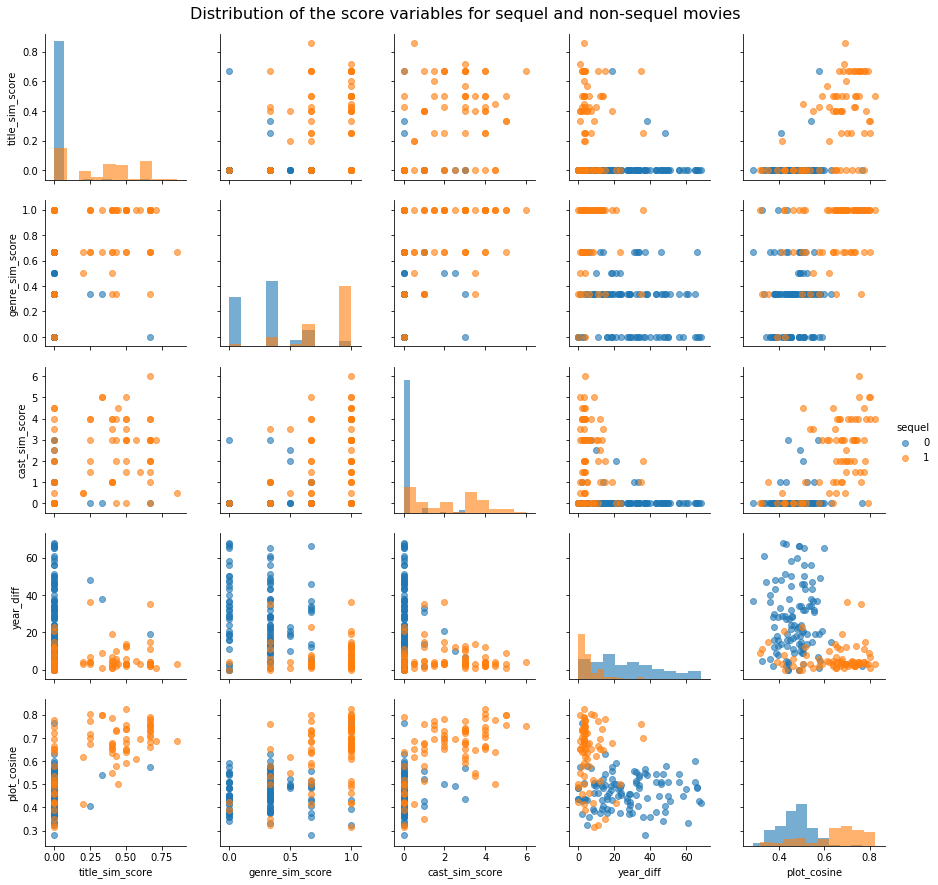

In [0]:
supervised_movie_pairs = movie_pairs[movie_pairs.sequel>=0]
model_features = ['title_sim_score','genre_sim_score','cast_sim_score','year_diff','plot_cosine']
g = sns.PairGrid(supervised_movie_pairs, hue="sequel", vars = model_features)
g = g.map_diag(plt.hist, alpha = 0.6)
g = g.map_offdiag(plt.scatter, alpha = 0.6)
g = g.add_legend()
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Distribution of the score variables for sequel and non-sequel movies', fontsize=16)
plt.show()

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

In [0]:
def balanced_train_test_split(X, y, n_training):
  
    positive_X = X[y == 1]
    negative_X = X[y == 0]
    positive_y = y[y == 1]
    negative_y = y[y == 0]

    if n_training > min(len(positive_y), len(negative_y)):
        raise ValueError('n_training larger than number of positives or negatives in the dataset')

    positive_train_indices = np.random.choice(len(positive_y), n_training, replace = False)
    negative_train_indices = np.random.choice(len(negative_y), n_training, replace = False)
    positive_test_indices = np.array([i for i in range(len(positive_y)) if i not in positive_train_indices])
    negative_test_indices = np.array([i for i in range(len(negative_y)) if i not in negative_train_indices])

    X_train = pd.concat([positive_X.iloc[positive_train_indices], negative_X.iloc[negative_train_indices]], axis = 0)
    X_test = pd.concat([positive_X.iloc[positive_test_indices], negative_X.iloc[negative_test_indices]], axis = 0)
    y_train = pd.concat([positive_y.iloc[positive_train_indices], negative_y.iloc[negative_train_indices]], axis = 0)
    y_test = pd.concat([positive_y.iloc[positive_test_indices], negative_y.iloc[negative_test_indices]], axis = 0)

    return X_train, X_test, y_train, y_test

In [0]:
from sklearn.metrics.pairwise import check_pairwise_arrays, euclidean_distances
from sklearn.semi_supervised import LabelPropagation, LabelSpreading


def rbf_kernel_safe(X, Y=None, gamma=None): 

    X, Y = check_pairwise_arrays(X, Y) 
    if gamma is None: 
        gamma = 1.0 / X.shape[1] 

    K = euclidean_distances(X, Y, squared=True) 
    K *= -gamma 
    K -= K.max() # Change to the sklearn implementation
    np.exp(K, K)
    return K 

In [0]:
n_training_list = np.arange(1,11)
RFC_score_list = []
LP_score_list = []
LP_more_unlabeled_score_list = []

for n_training in n_training_list:
  
    RFC_score = []
    LP_score = []
    LP_more_unlabeled_score = []

    for i in range(5):
  
        X_train, X_test, y_train, y_test = balanced_train_test_split(supervised_movie_pairs[model_features], supervised_movie_pairs.sequel, n_training = n_training)
        RFC = RandomForestClassifier(n_estimators = 100)
        LP = LabelPropagation(kernel = rbf_kernel_safe, tol = 0.01)


        RFC.fit(X_train, y_train)
        RFC_score.append(RFC.score(X_test, y_test))

        X = np.concatenate([X_train, X_test], axis = 0)
        y_unlabel = np.array([-1 for i in range(len(y_test))])
        y = np.concatenate([y_train, y_unlabel], axis = 0)

        LP.fit(X, y)
        LP_score.append(LP.score(X_test, y_test))

        X_unlabeled = movie_pairs[model_features][movie_pairs.sequel == -1]
        X = np.concatenate([X, X_unlabeled], axis = 0)
        y_unlabeled = np.array([-1 for i in range(X_unlabeled.shape[0])])
        y = np.concatenate([y, y_unlabeled], axis = 0)

        LP.fit(X, y)
        LP_more_unlabeled_score.append(LP.score(X_test, y_test))

    RFC_score_list.append(np.mean(RFC_score))
    LP_score_list.append(np.mean(LP_score))
    LP_more_unlabeled_score_list.append(np.mean(LP_more_unlabeled_score))

/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=2000 was reached without convergence.
  category=ConvergenceWarning
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=2000 was reached without convergence.
  category=ConvergenceWarning
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=2000 was reached without convergence.
  category=ConvergenceWarning
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/lab

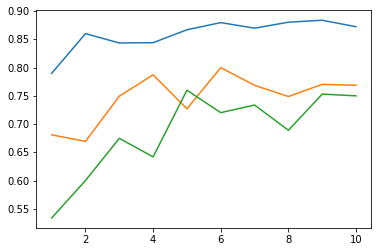

In [0]:
plt.plot(n_training_list, RFC_score_list)
plt.plot(n_training_list, LP_score_list)
plt.plot(n_training_list, LP_more_unlabeled_score_list)

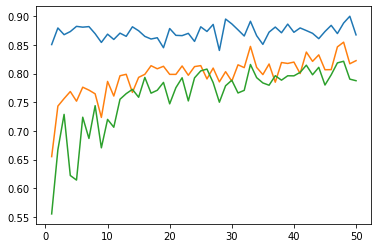

In [0]:
plt.plot(n_training_list, RFC_score_list)
plt.plot(n_training_list, LP_score_list)
plt.plot(n_training_list, LP_more_unlabeled_score_list)